# DQN - CartPole
* 내용 설명은 FrozenLake 노트북을 보자.

# 구현

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import gym
import tensorflow as tf
import random
import collections
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.keras import models, layers, optimizers, losses

In [3]:
# Hyperparameters
LR = 1e-3
GAMMA = .95
BUFFER_LIMIT = 100000
BATCH_SIZE = 1
EPISODES = 10000
EPOCHS = 10

In [4]:
class ReplayBuffer():
    def __init__(self):
        '''
        총 길이가 제한이 있는 que만들기
        '''
        self.buffer = collections.deque(maxlen=BUFFER_LIMIT)
        
    def put(self, transition):
        '''
        args:
            transitions: s, a, r, s', done(종료 step인지 아닌지 확인용)
        '''
        self.buffer.append(transition)
        
    def sample(self, n):
        '''
        args:
            샘플링할 개수 n
        return:
            replay buffer에 저장된 transition 중 n개 random sampling
        '''
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append(done_mask)
            
        return np.array(s_lst),np.array(a_lst),np.array(r_lst),np.array(s_prime_lst),np.array(done_mask_lst)
    
    def size(self):
        '''
        replay buffer 현재 크기 확인용
        '''
        return len(self.buffer)

In [5]:
class Qnet(models.Model):
    def __init__(self):
        '''
        3층 layer로 간단히 구현
        최종 layer는 value (real value 범위) 를 출력해야 하므로 activation function 없음
        '''
        super(Qnet, self).__init__()
        self.qnet = models.Sequential([
            layers.Dense(128, activation=tf.nn.relu),
            layers.Dense(128, activation=tf.nn.relu),
            layers.Dense(env.action_space.n)
        ])
        
    def call(self, x, training=False):
        '''
        args:
            state
        return:
            value (given s, a지만 a는 명시적으로 주지 않음)
        '''
        x = self.qnet(x, training=training)
        return x
    
    def sample_action(self, obs, epsilon):
        '''
        args:
            state
        return:
            epsilon greedy로 action 선택
        '''
        e = random.random()
        if e < epsilon:
            return env.action_space.sample()
        else:
            x = tf.squeeze(self.call(obs))
            return tf.argmax(x)

In [6]:
optimizer = optimizers.Adam(learning_rate=LR)
loss_func = losses.MeanAbsoluteError()

In [7]:
def train(q, q_target, memory):
    '''
    args:
        q: behaviour policy = mu
        q_target: target policy = pi
        memory: replay memory
    return:
        None
        모델 학습시킴
    '''
    for i in range(EPOCHS):
        s,a,r,s_prime,done_mask = memory.sample(BATCH_SIZE)

        with tf.GradientTape() as t:
            # state에 따른 value 뽑아냄
            q_out = q(s, training=True)
            q_out = tf.multiply(q_out, a)
            # 그 중에서 action 취한 value만 뽑아냄
            q_out = tf.reduce_max(q_out, axis=-1)

            # target, s'에 대한 value 계산
            max_q_prime = q_target(s_prime)
            # 그 중에서 max 인 value만 뽑아냄
            max_q_prime = tf.reduce_max(max_q_prime, axis=-1)

            target = r + GAMMA * max_q_prime * done_mask
            loss = loss_func(q_out, target)

        grads = t.gradient(loss, q.trainable_variables)
        optimizer.apply_gradients(list(zip(grads, q.trainable_variables)))

In [8]:
# epsilon: 1 부터 시작해서 최종 EPISODES 까지 선형적으로 .1이 되도록 줄어듦
f = lambda x: max(.8 - 1/EPISODES*x, .1)

In [9]:
tf.random.set_seed(0)

env = gym.make('CartPole-v0')
q = Qnet()
q_target = Qnet()
memory = ReplayBuffer()

In [10]:
def state_func(s):
    return tf.expand_dims(tf.cast(s,dtype=tf.float32), axis=0)

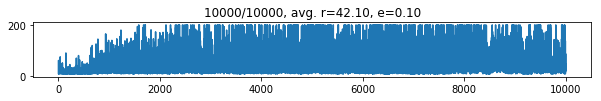

In [11]:
# theta로 부터 theta- 초기화 때 한 번만 복사할 flag
copy = True

r_list = []

for e in range(EPISODES):
    epsilon = f(e)
    s = env.reset()
    s = state_func(s)
    done = False
    
    r_sum = 0.
    
    while not done:
        # 주어진 state로부터 action 구함
        a = tf.squeeze(q.sample_action(s, epsilon))
        
        # (s,a) -> r, s' 구함
        s_prime, r, done, _ = env.step(int(a))
        done_mask = tf.zeros(1,) if done else tf.ones(1,)
        r_sum += r
        
        # action 을 one-hot encoding 해서 transition 에 저장
        _a = np.zeros((env.action_space.n,))
        _a[int(a)] = 1.
        a = tf.cast(_a, dtype=tf.float32)
        r = tf.expand_dims(r,axis=0)
        
        # state -> one-hot encoding 해서 transition 에 저장
        s_prime = state_func(s_prime)
        
        # (s, a, r, s') transition 을 저장해줌
        memory.put((s, a, r, s_prime, done_mask))
        
        # 다음 state s' 가 이제 현재 s가 됨
        s = s_prime.numpy()
        
        
        # 에피소드 끝
        if done:
            s = env.reset()
            s = state_func(s)
            r_list.append(r_sum)
            break
            
        if copy:
            q(memory.sample(1)[0])
            q_target(memory.sample(1)[0])
            q_target.set_weights(q.get_weights())
            copy = False
                        
    # transition 몇 개 이상 모이면 학습
    # 성공 경험이 있을 때 학습
    if memory.size() > 2000 and np.sum(r_list) > 0:
        train(q, q_target, memory)
        
    if e != 0 and e%20 == 0:
        
        # 가끔 behaviour 를 target에 복사해줌
        q_target.set_weights(q.get_weights())
        
    ipd.clear_output(wait=True)
    plt.figure(facecolor='w',figsize=(10,1))
    plt.plot(r_list)
    plt.title(f"{e+1}/{EPISODES}, avg. r={np.sum(r_list[-10:])/10:.2f}, e={epsilon:.2f}")
    plt.show()
        
env.close()

In [22]:
TEST_EPISODES = 100
r_list = []
for i in range(TEST_EPISODES):
    s = env.reset()
    s = state_func(s)
    done = False

    r_sum = 0.

    while not done:
        # 주어진 state로부터 action 구함
        a = tf.squeeze(q.sample_action(s, epsilon))

        # (s,a) -> r, s' 구함
        s_prime, r, done, _ = env.step(int(a))
        r_sum += r

        # state -> one-hot encoding 해서 transition 에 저장
        s_prime = state_func(s_prime)

        # 다음 state s' 가 이제 현재 s가 됨
        s = s_prime.numpy()

        # 에피소드 끝
        if done:
            r_list.append(r_sum)
            r_sum = 0
            s = env.reset()
            s = state_func(s)
            break

In [25]:
print(f"N = {TEST_EPISODES}, mean = {np.mean(r_list)}, std = {np.std(r_list)}")

N = 100, mean = 130.65, std = 18.304302772845514


In [27]:
# q.save_weights('model/dqn-cartpole')